In [14]:
%pylab inline --no-import-all
import seaborn as sns
import scipy as sp
import scipy.ndimage
from sklearn.neural_network import MLPClassifier

Populating the interactive namespace from numpy and matplotlib


Downloading MNIST datased. I use just test samle of mnist dataset (as it's much smaller in size)

**P.S.: it takes about 2MB, so this can take some time**

In [15]:
import requests
import gzip
images_r = requests.get('http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz')
labels_r = requests.get('http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz')

with open("/tmp/images", "wb") as f:
    f.write(gzip.decompress(images_r.content))
with open("/tmp/labels", "wb") as f:
    f.write(gzip.decompress(labels_r.content))

In [16]:
import os, struct
from array import array

def read_mnist(digits, fname_img, fname_lbl):
    flbl = open(fname_lbl, 'rb')
    magic_nr, size = struct.unpack(">II", flbl.read(8))
    lbl = array("b", flbl.read())
    flbl.close()

    fimg = open(fname_img, 'rb')
    magic_nr, size, rows, cols = struct.unpack(">IIII", fimg.read(16))
    img = array("B", fimg.read())
    fimg.close()

    ind = [ k for k in range(size) if lbl[k] in digits ]
    images =  np.zeros((len(ind), rows*cols))
    labels = np.zeros((len(ind), 1))
    for i in range(len(ind)):
        images[i, :] = list(img[ ind[i]*rows*cols : (ind[i]+1)*rows*cols ])
        labels[i] = lbl[ind[i]]

    return images, labels

Read MNIST dataset and convert result to numpy arrays

In [156]:
images, labels = read_mnist(list(range(0, 10)), "/tmp/images", "/tmp/labels")
images = np.array(images)
labels = np.array(labels)

Let's try to clean our images by morphology and thresholding

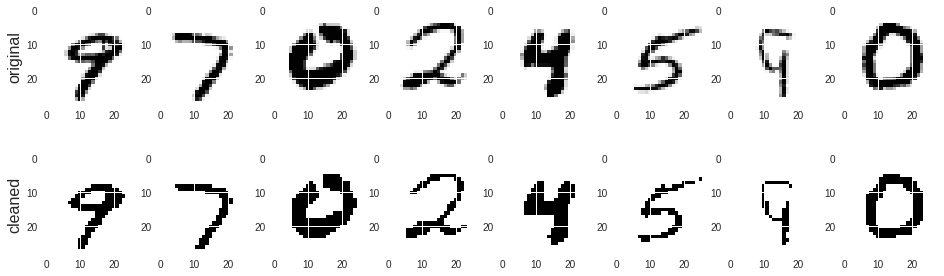

In [157]:
clean_images = np.apply_along_axis(lambda arr: sp.ndimage.grey_erosion(arr.reshape((28, 28)), size=(2,2)).reshape(28*28),
                           1, images)
threshold = 20
clean_images = np.where(clean_images > threshold, 1, 0).astype(int)

examples = 8
fig, axes = plt.subplots(2, examples, figsize=(16, 5))
for col in range(examples):
    ex = col * 10 + np.random.randint(0, 10)
    axes[0, col].imshow(images[ex].reshape(28, 28))
    axes[1, col].imshow(clean_images[ex].reshape(28, 28))
    
axes[0, 0].set_ylabel("original", size=16)
axes[1, 0].set_ylabel("cleaned", size=16)

Split data to train and test sets

In [158]:
trainX, testX = np.split(clean_images, [9000])
trainY, testY = np.split(labels.astype(int), [9000])

Create multilayer perceptron classifier

In [159]:
clf = MLPClassifier(hidden_layer_sizes=(100, 50, 10)) # 3 hidden layers with 100, 50 and 10 neurons respectively

Train the classifier

In [160]:
clf.fit(trainX, trainY.reshape(trainY.shape[0]))

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100, 50, 10), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

Predict on test set

In [161]:
predictions = clf.predict(testX)

Check predictions accuracy

In [162]:
print("Accuracy is {:.2f}%".format(100 * np.sum(predictions == testY.reshape(testY.shape[0])) / predictions.shape[0]))

Accuracy is 91.90%


Now let's see how frequently certain digits were not recognized and what's was recognized instead 

In [163]:
def what_is_predicted(predictions, instead_of):
    return predictions[np.all(
        (predictions.reshape(predictions.shape[0], 1) != testY, testY == instead_of),
        axis=0).reshape(predictions.shape)]

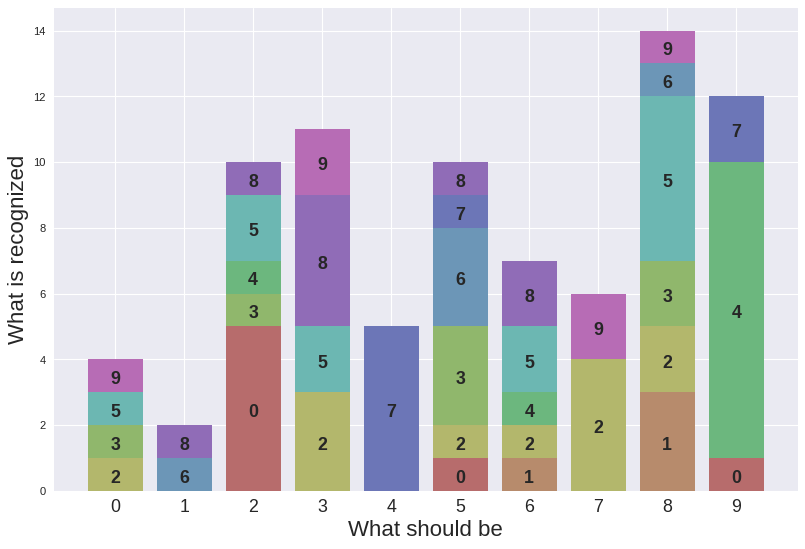

In [164]:
fig, ax = plt.subplots(figsize=(12, 8), dpi=80)
colors = [
    "#EB6B52",
    "#F4A148",
    "#F3F448",
    "#99F448",
    "#48F494",
    "#48F4EE",
    "#4883F4",
    "#8B48F4",
    "#D248F4",
    "#F448A9"    
]
colors2 = [
    "#B76C6C",
    "#B78B6C",
    "#B3B76C",
    "#90B76C",
    "#6CB77E",
    "#6CB7B2",
    "#6C96B7",
    "#6C76B7",
    "#906CB7",
    "#B76CB5"
]
plt.xticks(np.arange(10), size=16)
plt.xlabel("What should be", size=20)
plt.ylabel("What is recognized", size=20)


wrong_numbers = [np.bincount(what_is_predicted(predictions, i)) for i in range(0, 10)]
result = []
for i, num in enumerate(wrong_numbers):
    bottom = 0
    for j, error in enumerate(num):
        if error:
            result.append(ax.bar(i, error, bottom=bottom, color=colors2[j]))
            ax.text(i, bottom + error*0.5 - 0.1, j,
                    verticalalignment='center',
                    horizontalalignment='center',
                    size=16, weight='bold')
            bottom += error


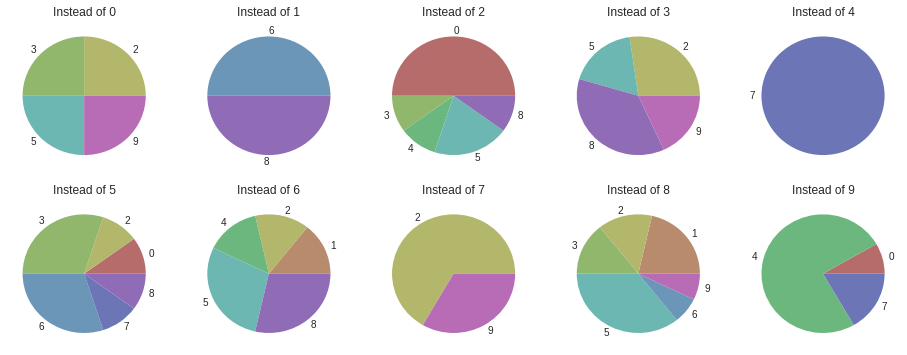

In [165]:
fig, axes = plt.subplots(2, 5, figsize=(16, 6))

for i, num in enumerate(wrong_numbers):
    position = (int(i > 4), i % 5)
    labels = list(map(lambda x: str(x) if num[x] > 0 else "", list(range(len(num)))))
    axes[position].pie(num, labels=labels, colors=colors2)
    axes[position].set_title("Instead of {:d}".format(i))
